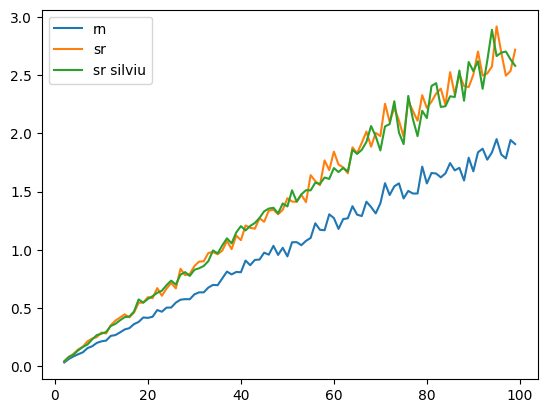

In [3]:
import srfloat as sr
import math
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp, mpf
from mptorch.quant import binary8_quantize
import torch


cast_binary16_sr_silviu = lambda x : sr.cast_sr(x, 3, 4, 20, True, False)
cast_binary16_rn_silviu = lambda x : sr.cast_rn(x, 3, 4, True, False)

cast_binary16_sr = lambda x : binary8_quantize(torch.tensor(x, dtype=torch.float32, device="cuda"), 4, "stochastic", "saturate", True, True, 23).item()#sr.cast_sr(x, 3, 4, 20, True, False)
cast_binary16_rn = lambda x : binary8_quantize(torch.tensor(x, dtype=torch.float32, device="cuda"), 4, "nearest", "saturate", True, True).item()#sr.cast_rn(x, 3, 4, True, False)


runs = 500
Ns = [n for n in range(2, 100)]
errs_rn = []
errs_sr = []
errs_rn_silviu = []
errs_sr_silviu = []
for N in Ns:
    e_rn = []
    e_sr = []
    e_rn_silviu = []
    e_sr_silviu = []
    for i in range(runs):
        xs = [(-1 if x < 0 else 1) * cast_binary16_rn(x**2) for x in np.random.randn(N).tolist()]
        sum_rn = 0.0
        sum_float = 0.0
        sum_mp = mpf(0.0)
        sum_sr = 0.0
        sum_sr_silviu = 0.0
        sum_rn_silviu = 0.0
        for i in range(0, len(xs)):
            sum_float += xs[i]
            sum_mp += mpf(xs[i])
            sum_rn = cast_binary16_rn(sum_rn + xs[i])
            sum_sr = cast_binary16_sr(sum_sr + xs[i])
            sum_sr_silviu = cast_binary16_sr_silviu(sum_sr_silviu + xs[i])
            sum_rn_silviu = cast_binary16_rn_silviu(sum_rn_silviu + xs[i])

        err_float = mp.fabs(mpf(sum_float) - sum_mp)
        err_rn = mp.fabs(mpf(sum_rn) - sum_mp)
        err_sr = mp.fabs(mpf(sum_sr) - sum_mp)
        err_sr_silviu = mp.fabs(mpf(sum_sr_silviu) - sum_mp)
        err_rn_silviu = mp.fabs(mpf(sum_rn_silviu) - sum_mp)
        e_rn.append(err_rn)
        e_sr.append(err_sr)
        e_rn_silviu.append(err_rn_silviu)
        e_sr_silviu.append(err_sr_silviu)
    errs_rn.append(np.mean(np.array(e_rn)))
    errs_sr.append(np.mean(np.array(e_sr)))
    errs_rn_silviu.append(np.mean(np.array(e_rn_silviu)))
    errs_sr_silviu.append(np.mean(np.array(e_sr_silviu)))

plt.plot(Ns, errs_rn, label='rn')
plt.plot(Ns, errs_sr, label='sr')
plt.plot(Ns, errs_rn_silviu, label='rn silviu')
plt.plot(Ns, errs_sr_silviu, label='sr silviu')
plt.legend()
plt.show()
